In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import mplcyberpunk
import seaborn as sns

plt.style.use("cyberpunk")

In [2]:
# Import Custom Modules
from src.cleaner import *

In [3]:
"""Realtime Events API Client for DSI Fraud Detection Case Study"""
import time
import requests
import pymongo


class EventAPIClient:
    """Realtime Events API Client"""

    def __init__(self, first_sequence_number=0,
                 api_url='https://hxobin8em5.execute-api.us-west-2.amazonaws.com/api/',
                 api_key='vYm9mTUuspeyAWH1v-acfoTlck-tCxwTw9YfCynC',
                 db=None,
                 interval=30):
        """Initialize the API client."""
        self.next_sequence_number = first_sequence_number
        self.api_url = api_url
        self.api_key = api_key
        self.db = db
        self.interval = 30
        self.data = []

    def save_to_database(self, row):
        """Save a data row to the database."""
        self.data.append(row)

    def get_data(self):
        """Fetch data from the API."""
        payload = {'api_key': self.api_key,
                   'sequence_number': self.next_sequence_number}
        response = requests.post(self.api_url, json=payload)
        data = response.json()
        self.next_sequence_number = data['_next_sequence_number']
        return data['data']

    def collect(self, interval=60):
        """Check for new data from the API periodically."""
        for _ in range(20):
            print("Requesting data...")
            data = self.get_data()
            if data:
                print("Saving...")
                for row in data:
                    self.save_to_database(row)
            else:
                print("No new data received.")
            print(f"Waiting {interval} seconds...")
            time.sleep(interval)

In [4]:
event_api = EventAPIClient()

In [5]:
# event_api.collect()

In [6]:
# len(event_api.data)

In [7]:
def re_add_features(data:pd.DataFrame, data2:pd.DataFrame) -> pd.DataFrame:
    """ Adds wanted features back from original dataframe """
    res = data.copy()
    from_ = data2.copy()
    
    res['event_created'] = from_['event_created']
    res['event_end'] = from_['event_end']
    res['event_published'] = from_['event_published']
    res['user_created'] = from_['user_created']
    

    return res

In [8]:
# Import Data
data = pd.read_json('data/data.json')
# Clean Data
df = clean_with_target(data)

In [9]:
df = re_add_features(df, data)
df.head(2)

,channels,country,currency,delivery_method,email_domain,fb_published,has_logo,listed,payee_name,payout_type,...,venue_latitude,venue_longitude,fraud,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan,event_created,event_end,event_published
0,5,840,840,0.0,gmail.com,0,0,1,,3,...,25.777471,-80.133433,1,0,36000,370132.0,3125756,1262739706,1265630400,1.263110e+09
1,0,840,840,1.0,ruf.org,0,1,0,RUF,2,...,32.776566,-79.930922,0,49,32400,625.0,12889894,1293832670,1296288000,1.293833e+09


In [10]:
# Sort in Chronological Order
df.sort_values(by='event_end', inplace=True)

In [11]:
from datetime import datetime

df['event_end'] = df['event_end'].apply(lambda x: datetime.fromtimestamp(x).date())

In [12]:
# Set up date for graphing
fraud_over_time  = df[['event_end', 'fraud']].copy()
fraud_over_time['date'] = fraud_over_time['event_end']
fraud_over_time.drop(columns=['event_end'], inplace=True)

fraud_over_time['date'] = pd.to_datetime(fraud_over_time['date'], infer_datetime_format=True)

# fraud_over_time = fraud_over_time.set_index('date')

fraud_over_time = fraud_over_time.groupby(by='date').count()

# fraud_over_time

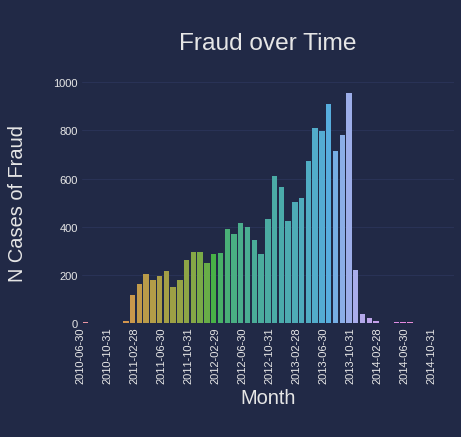

In [15]:
# Plot over Time
alpha_col = 0.7
colors = ["g", "deeppink", "dodgerblue", "orange", "white", "purple", "red"]

# set the frequency for labelling the yaxis
freq = int(4)


# Set Start date to 2010-2015
fraud_over_time = fraud_over_time[datetime(2010, 6, 1):]
fraud_over_time = fraud_over_time[:datetime(2015, 6, 1)]

fraud_count_culmulative = fraud_over_time.resample('M').sum()


fig, ax = plt.subplots(dpi=80)

fig = sns.barplot(x = fraud_count_culmulative.index, y = fraud_count_culmulative["fraud"], 
                  estimator = sum, ci = None, ax=ax, orient='v')

x_dates = [datetime.date(x) for x in fraud_count_culmulative.index.tolist()]


# Decoration
plt.title('\nFraud over Time\n', fontsize=22)
plt.xlabel("Month\n", fontsize=18)
plt.ylabel("N Cases of Fraud\n", fontsize=18)

ax.set_xticklabels(fraud_count_culmulative.index[::freq])
xtix = ax.get_xticks()
ax.set_xticks(xtix[::freq])
ax.set_xticklabels(labels=x_dates[::freq], rotation=90, ha='right')

mplcyberpunk.add_glow_effects()
mplcyberpunk.add_underglow()

plt.savefig('images/timeseries.png', bbox_inches='tight', dpi=250)


In [14]:
# def display_timeseries():
#     data = db.fraud_detection.find()
#     count = Counter()
#     for i in data:
#         count[i['data']['country']] += 1
#     fig, ax = plt.subplots()
#     x = np.arange(len(count.keys()))
#     y = count.values()
#     alpha_col = 0.7
#     colors = ["g", "deeppink", "dodgerblue", "orange", "white", "purple", "red"]
#     ax.bar(x, y, color=colors, alpha=alpha_col)
#     mplcyberpunk.add_glow_effects()
#     mplcyberpunk.add_underglow()
#     fig.savefig('static/current.png')
#     return render_template('dashboard.html')